# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('/gdrive/My Drive/Colab Notebooks/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 348260/348260 [02:01<00:00, 2876.67it/s]


In [25]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

final["preprocessed_reviews"] = preprocessed_reviews

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_reviews
138702,150520,0006641040,ADBFSA9KTQANE,"James L. Hammock ""Pucks Buddy""",0,0,1,1256688000,Great Gift,This book was purchased as a birthday gift for...,book purchased birthday gift year old boy sque...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138692,150510,0006641040,AM1MNZMYMS7D8,Dr. Joshua Grossman,0,0,1,1348358400,Professional Mentoring,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...,title chicken soup riceauthor maurice sendakre...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...


In [0]:
final=final.drop(["Id","ProductId","UserId","ProfileName","HelpfulnessNumerator"],axis=1)

In [0]:
final_last=final.drop(["HelpfulnessDenominator","Time","Summary","Text"],axis=1)

In [30]:
final_last.shape

(348260, 2)

In [31]:
final_last.head()

,Score,preprocessed_reviews
138702,1,book purchased birthday gift year old boy sque...
138707,1,daughter loves really rosie books introduced r...
138708,0,one best children books ever written mini vers...
138692,1,title chicken soup riceauthor maurice sendakre...
138689,1,fun way children learn months year learn poems...


# [4] Featurization

In [0]:
X = final_last["preprocessed_reviews"][:50000]

Y = final_last["Score"][:50000]

In [33]:
X.head()

138702    book purchased birthday gift year old boy sque...
138707    daughter loves really rosie books introduced r...
138708    one best children books ever written mini vers...
138692    title chicken soup riceauthor maurice sendakre...
138689    fun way children learn months year learn poems...
Name: preprocessed_reviews, dtype: object

In [34]:
X.shape

(50000,)

In [0]:
from sklearn.model_selection import train_test_split
x_train ,x_test ,y_train ,y_test = train_test_split(X , Y ,test_size = 0.33 , random_state = 0)

In [36]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

Using TensorFlow backend.


In [37]:
print(x_train[1])
print(len(x_train[1]))

[746, 39, 44, 552, 1780, 1041, 67, 1063, 14, 6, 277, 9, 732, 2092, 104, 250, 192, 2377, 201, 23, 1100, 74, 87, 364, 725, 11, 67, 80, 464, 187, 2, 131, 129, 795, 322, 197, 6, 1565]
38


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import keras

In [39]:
# truncate and/or pad input sequences

max_review_length = 600
x_train = sequence.pad_sequences(x_train , maxlen = max_review_length)
x_test = sequence.pad_sequences(x_test ,maxlen = max_review_length)

print(x_train.shape)
print(x_train[1])
                                 

(33500, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

# Model with 1 LSTM layer

In [40]:
top_words = 5000
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words ,embedding_vector_length , input_length = max_review_length))

model.add(LSTM(100))

model.add(Dense(1 ,activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy' ,optimizer = 'adam' ,metrics =['accuracy'])

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
history = model.fit(x_train ,y_train,
          validation_data = (x_test ,y_test),
          nb_epoch = 10,
          batch_size = 64
         )

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 33500 samples, validate on 16500 samples
Epoch 1/10
33500/33500 [==============================] - 522s 16ms/step - loss: 0.2761 - acc: 0.8926 - val_loss: 0.2414 - val_acc: 0.8993
Epoch 2/10
33500/33500 [==============================] - 516s 15ms/step - loss: 0.1833 - acc: 0.9284 - val_loss: 0.2134 - val_acc: 0.9178
Epoch 3/10
33500/33500 [==============================] - 516s 15ms/step - loss: 0.1625 - acc: 0.9391 - val_loss: 0.2418 - val_acc: 0.9138
Epoch 4/10
33500/33500 [==============================] - 517s 15ms/step - loss: 0.1479 - acc: 0.9440 - val_loss: 0.2331 - val_acc: 0.9114
Epoch 5/10
33500/33500 [==============================] - 519s 15ms/step - loss: 0.1315 - acc: 0.9520 - val_loss: 0.2474 - val_acc: 0.9123
Epoch 6/10
33500/33500 [==============================] - 525s 16ms/step - loss: 0.1197 - acc: 0.9571 - val_loss: 0.2511 - val_acc: 0.9041
Epoch 7/10
33500/33500 [==============================] - 514s 15ms/step - loss: 0.1020 - acc: 0.9634 - val_loss: 0.

In [42]:
#Final evaluation of the model

scores = model.evaluate(x_test ,y_test ,verbose = 0)
print("Accuracy : %.2f%%" %(scores[1]*100))

Accuracy : 90.40%


In [0]:
import matplotlib.pyplot as plt
def plt_dynamic(x, vy, ty):
    plt.figure(figsize=(10,5))
    plt.plot(x, vy, 'b', label="Validation Loss")
    plt.plot(x, ty, 'r', label="Train Loss")
    plt.xlabel('Epochs') 
    plt.ylabel('Binary Crossentropy Loss')
    plt.title('Binary Crossentropy Loss VS Epochs')
    plt.legend()
    plt.grid()
    plt.show()

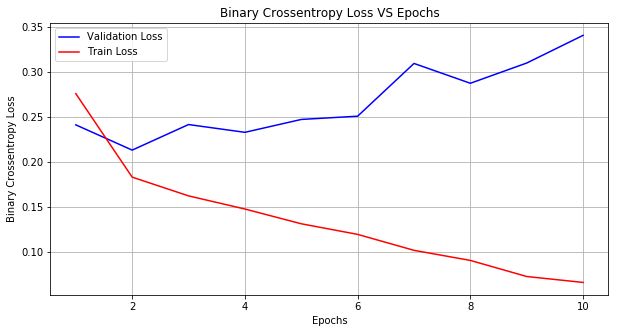

In [44]:
x = list(range(1,11))

train_acc_1 = history.history["acc"]
val_acc_1 = history.history["val_acc"]
val_loss_1 = history.history["val_loss"]
train_loss_1 = history.history["loss"]

plt_dynamic(x , val_loss_1 , train_loss_1)

# Model with 2 LSTM layers and 1 Dropout in between LSTM's

In [53]:
model_2 = Sequential()
model_2.add(Embedding(top_words ,embedding_vector_length , input_length = max_review_length))

model_2.add(LSTM(100 ,return_sequences = True))
model_2.add(keras.layers.Dropout(0.25))
model_2.add(LSTM(100))

model_2.add(Dense(1 ,activation = 'sigmoid'))
model_2.compile(loss = 'binary_crossentropy' ,optimizer = 'adam' ,metrics =['accuracy'])

print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 600, 100)          53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
history_2 = model_2.fit(x_train ,y_train,
          validation_data = (x_test ,y_test),
          nb_epoch = 10,
          batch_size = 64
         )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 33500 samples, validate on 16500 samples
Epoch 1/10
33500/33500 [==============================] - 1013s 30ms/step - loss: 0.2667 - acc: 0.8966 - val_loss: 0.2157 - val_acc: 0.9145
Epoch 2/10
33500/33500 [==============================] - 1002s 30ms/step - loss: 0.1825 - acc: 0.9300 - val_loss: 0.2143 - val_acc: 0.9172
Epoch 3/10
33500/33500 [==============================] - 1000s 30ms/step - loss: 0.1582 - acc: 0.9406 - val_loss: 0.2306 - val_acc: 0.9144
Epoch 4/10
33500/33500 [==============================] - 995s 30ms/step - loss: 0.1379 - acc: 0.9487 - val_loss: 0.2382 - val_acc: 0.9061
Epoch 5/10
33500/33500 [==============================] - 995s 30ms/step - loss: 0.1158 - acc: 0.9579 - val_loss: 0.2474 - val_acc: 0.9061
Epoch 6/10
33500/33500 [==============================] - 987s 29ms/step - loss: 0.0955 - acc: 0.9663 - val_loss: 0.2733 - val_acc: 0.9080
Epoch 7/10
33500/33500 [==============================] - 983s 29ms/step - loss: 0.0800 - acc: 0.9724 - val_loss:

In [55]:
#Final evaluation of the model

scores_2 = model_2.evaluate(x_test ,y_test ,verbose = 0)
print("Accuracy : %.2f%%" %(scores_2[1]*100))

Accuracy : 90.36%


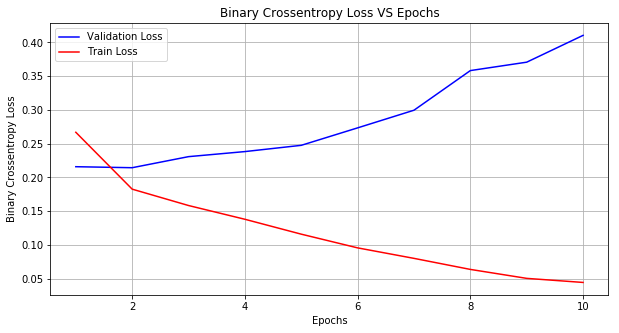

In [56]:
x = list(range(1,11))

train_acc_2 = history_2.history["acc"]
val_acc_2 = history_2.history["val_acc"]
val_loss_2 = history_2.history["val_loss"]
train_loss_2 = history_2.history["loss"]

plt_dynamic(x , val_loss_2 , train_loss_2)

# Model with 1 LSTM layer and 1 Dropout

In [58]:
model_3 = Sequential()
model_3.add(Embedding(top_words , embedding_vector_length ,input_length = max_review_length))

model_3.add(LSTM(100))
model_3.add(keras.layers.Dropout(0.50))

model_3.add(Dense(1, activation = 'sigmoid'))

model_3.compile(loss = 'binary_crossentropy' ,optimizer = 'adam' ,metrics = ["accuracy"])

print(model_3.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 600, 32)           160000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
history_3 = model_3.fit(x_train ,y_train ,
                       validation_data = (x_test ,y_test),
                       nb_epoch = 10,
                       batch_size = 64)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 33500 samples, validate on 16500 samples
Epoch 1/10
33500/33500 [==============================] - 515s 15ms/step - loss: 0.2852 - acc: 0.8923 - val_loss: 0.2131 - val_acc: 0.9146
Epoch 2/10
33500/33500 [==============================] - 510s 15ms/step - loss: 0.1851 - acc: 0.9299 - val_loss: 0.2240 - val_acc: 0.9118
Epoch 3/10
33500/33500 [==============================] - 513s 15ms/step - loss: 0.1597 - acc: 0.9407 - val_loss: 0.2227 - val_acc: 0.9127
Epoch 4/10
33500/33500 [==============================] - 516s 15ms/step - loss: 0.1396 - acc: 0.9480 - val_loss: 0.2221 - val_acc: 0.9110
Epoch 5/10
33500/33500 [==============================] - 513s 15ms/step - loss: 0.1198 - acc: 0.9570 - val_loss: 0.2482 - val_acc: 0.9070
Epoch 6/10
33500/33500 [==============================] - 512s 15ms/step - loss: 0.1051 - acc: 0.9619 - val_loss: 0.2781 - val_acc: 0.9092
Epoch 7/10
33500/33500 [==============================] - 509s 15ms/step - loss: 0.0880 - acc: 0.9699 - val_loss: 0.

In [60]:
scores_3 = model_3.evaluate(x_test, y_test)
print("Accuracy : %.2f%%"%(scores_3[1]*100))

16500/16500 [==============================] - 157s 10ms/step
Accuracy : 90.33%


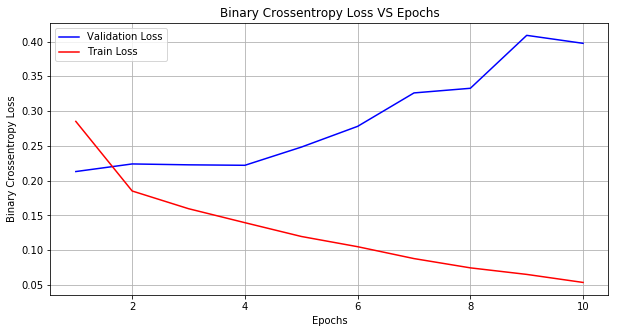

In [62]:
x = list(range(1,11))

train_acc_3 = history_3.history["acc"]
val_acc_3 = history_3.history["val_acc"]
val_loss_3 = history_3.history["val_loss"]
train_loss_3 = history_3.history["loss"]

plt_dynamic(x , val_loss_3 , train_loss_3)

In [66]:
from prettytable import PrettyTable

x = PrettyTable()

x.add_column("S.no" ,[1,2,3])
x.add_column("Model" ,["Model with 1 LSTM" ,"Model with 2 LSTM's and 1 Dropout" ,"Model with 1 LSTM and 1 Dropout"])
x.add_column("Train Accuracy" ,[train_acc_1[-1] ,train_acc_2[-1] ,train_acc_3[-1]])
x.add_column("Validation Accuracy" ,[val_acc_1[-1] ,val_acc_2[-1] ,val_acc_3[-1]])
x.add_column("Training Loss" ,[train_loss_1[-1] ,train_loss_2[-1] ,train_loss_3[-1]])
x.add_column("Validation loss" ,[val_loss_1[-1] ,val_loss_2[-1] ,val_loss_3[-1]])

print(x)

+------+-----------------------------------+--------------------+---------------------+----------------------+---------------------+
| S.no |               Model               |   Train Accuracy   | Validation Accuracy |    Training Loss     |   Validation loss   |
+------+-----------------------------------+--------------------+---------------------+----------------------+---------------------+
|  1   |         Model with 1 LSTM         | 0.9776417910590101 |  0.9040000000288992 | 0.06633607944890635  | 0.34087321477947813 |
|  2   | Model with 2 LSTM's and 1 Dropout | 0.9865671641791045 |  0.9035757576480057 | 0.044292764223000006 |  0.4103275627222928 |
|  3   |  Model with 1 LSTM and 1 Dropout  | 0.9828059701279028 |  0.9033333333622325 | 0.05367634193532503  |  0.397397007595409  |
+------+-----------------------------------+--------------------+---------------------+----------------------+---------------------+
